# **Adım 1: Gerekli Kütüphaneleri Yükleme**

Gerekli kütüphaneleri yüklüyoruz.

    •	os ile dosya ve klasör işlemlerini yapabiliyoruz. Görüntülerin dizinlerden okunmasını kolaylaştırıyor.
    •	numpy, verileri sayısal bir formatta işleyebilmemiz için diziler oluşturuyor.
    •	matplotlib.pyplot ile grafikler çizip modelimizin performansını görselleştirebiliyoruz.
    •	cv2, görüntü işleme için çok güçlü bir araç. Görüntüleri okuyup işleyebiliyoruz.
    •	sklearn.model_selection’daki train_test_split ile veri setimizi eğitim ve test olarak ayırıyoruz.

TensorFlow ve Keras araçlarını projeye dahil ediyoruz.

    •	tensorflow.keras.models.Sequential ile modelimizi adım adım oluşturabiliyoruz.
    •	Conv2D ve MaxPooling2D ile evrişimsel katmanlar (CNN) ekliyoruz.
    •	Flatten veriyi düzleştiriyor, Dense ise tam bağlantılı katmanları oluşturuyor.
    •	Dropout ile aşırı öğrenmeyi (overfitting) önlemek için nöronları rastgele devre dışı bırakıyoruz.

Görüntüleri augment (veri artırma) etmek için ImageDataGenerator’ı ve optimizasyon için Adam optimizatörünü ekliyoruz.


In [2]:
# Gerekli kütüphanelerin yüklenmesi
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


# **Adım 2: On Hayvanın Ayıklanması**

In [3]:
# Initialize the dictionary to hold paths for each animal
image_paths = {}

# Base directory for your dataset
base_path = "Animals_with_Attributes2/JPEGImages"

# List of animals to search for
animals = ["collie", "dolphin", "elephant", "fox", "moose", "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]

# Traverse the directory structure
for dirname, _, filenames in os.walk(base_path):
    for animal in animals:
        # Check if the current directory contains the animal's name
        if animal in dirname:
            # Initialize the list if the animal is encountered for the first time
            if animal not in image_paths:
                image_paths[animal] = []
            # Add all image paths for the current animal
            for filename in filenames:
                image_paths[animal].append(os.path.join(dirname, filename))

# Print the paths for verification
for animal, paths in image_paths.items():
    print(f"{animal}: {len(paths)} images")


giant+panda: 874 images
moose: 704 images
fox: 664 images
dolphin: 946 images
polar+bear: 868 images
sheep: 1420 images
collie: 1028 images
rabbit: 1088 images
squirrel: 1200 images
elephant: 1038 images


In [ ]:
for animal, paths in image_paths.items():
    print(f"{animal}: {paths}")

# **Adım 3: Sınıfları Hazırlama**

In [4]:
# Görüntü boyutu (örneğin, 128x128)
image_size = (128, 128)

# Eğitim ve test setleri için boş listeler
X = []
y = []

# Hayvan etiketlerini sayısal değerlere eşleştirme
animal_to_label = {animal: i for i, animal in enumerate(animals)}

# Her sınıftan 650 görüntü al
for animal, paths in image_paths.items():
    print(f"Processing {animal}...")
    # İlk 650 görüntüyü seç
    selected_paths = paths[:650]
    for path in selected_paths:
        # Görüntüyü okuma
        img = cv2.imread(path)
        if img is not None:
            # Görüntüyü yeniden boyutlandır ve normalize et
            img_resized = cv2.resize(img, image_size)
            img_normalized = img_resized / 255.0
            # X listesine ekle
            X.append(img_normalized)
            # y listesine sınıf etiketini ekle
            y.append(animal_to_label[animal])

# X ve y'yi numpy dizilerine dönüştürme
X = np.array(X)
y = np.array(y)

print(f"Toplam görüntü sayısı: {X.shape[0]}")
print(f"Görüntü boyutu: {X.shape[1:]}")
print(f"Etiketlerin boyutu: {y.shape}")

Processing giant+panda...
Processing moose...
Processing fox...
Processing dolphin...
Processing polar+bear...
Processing sheep...
Processing collie...
Processing rabbit...
Processing squirrel...
Processing elephant...
Toplam görüntü sayısı: 6500
Görüntü boyutu: (128, 128, 3)
Etiketlerin boyutu: (6500,)


# **Adım 4: Veriyi Eğitim ve Test Setlerine Ayırma**

Bu kodda, elimizdeki veriyi %70 eğitim ve %30 test olarak ikiye ayırıyoruz. Bunu, CNN modelimizi eğitmek ve test etmek için yapıyoruz. train_test_split fonksiyonu sayesinde giriş verileri (X) ve etiketleri (y) rastgele bir şekilde ayrılıyor. Son olarak, veri boyutlarını ekrana yazdırarak kontrol ediyoruz.

In [5]:
# Veriyi %70 eğitim ve %30 test olarak ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Eğitim veri boyutu: {X_train.shape}, Etiket boyutu: {y_train.shape}")
print(f"Test veri boyutu: {X_test.shape}, Etiket boyutu: {y_test.shape}")

Eğitim veri boyutu: (4550, 128, 128, 3), Etiket boyutu: (4550,)
Test veri boyutu: (1950, 128, 128, 3), Etiket boyutu: (1950,)


# **Adım 5: Veri Artırma (Augmentation)**

Bu adımda, eğitim verilerimizi çeşitlendirmek için veri artırımı (data augmentation) işlemi yapıyoruz.
Neler yapıyoruz?

	1.	Görüntüler üzerinde dönüş (rotation), kaydırma (shift), yakınlaştırma (zoom), ve yatay çevirme (horizontal flip) gibi rastgele değişiklikler uygulayarak veri setimizi genişletiyoruz.
	2.	ImageDataGenerator ile bu işlemleri tanımlıyoruz.
	3.	Eğitim verisini artırıma uygun hale getirmek için datagen.fit(X_train) kullanıyoruz.

Bu işlemin amacı, modelin farklı varyasyonlarla daha iyi genelleme yapabilmesini sağlamak.

In [8]:
# Veri artırımı işlemleri
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Eğitim verisine veri artırımı uygulama
datagen.fit(X_train)

print("Veri artırma işlemi tamamlandı.")

Veri artırma işlemi tamamlandı.


# **Adım 6: CNN Modelinin Tasarımı**

Bu kodda, bir Convolutional Neural Network (CNN) modeli tasarlıyoruz ve sınıflandırma problemi için derliyoruz.

CNN Modelini Oluşturuyoruz

	•	Konvolüsyon Katmanları (Conv2D): Görsellerin özelliklerini öğrenen katmanlar ekliyoruz. Katmanlar giderek daha fazla filtre içeriyor (32, 64, 128, 256), bu da modelin daha karmaşık özellikleri öğrenmesini sağlıyor.
	•	Batch Normalization: Katmanların aktivasyon çıktısını normalize ederek eğitim sürecini hızlandırıyoruz ve daha kararlı hale getiriyoruz.
	•	MaxPooling: Görüntünün boyutunu küçültüp önemli bilgileri koruyoruz.
	•	Dropout: Rastgele nöronları devre dışı bırakarak overfitting’i azaltıyoruz.
	•	Flatten: Konvolüsyon katmanlarından gelen veriyi tam bağlantılı katmanlara uygun hale getiriyoruz.
	•	Dense (Tam Bağlantılı Katmanlar): Sınıflandırma için son aşamada nöronları birleştiriyoruz. Çıkışta, her sınıf için bir olasılık veren softmax aktivasyonu kullanıyoruz.

Modeli Derliyoruz

	•	Optimizasyon: adam optimizatörüyle ağırlıkları öğreniyoruz.
	•	Kayıp Fonksiyonu: sparse_categorical_crossentropy kullanarak çok sınıflı sınıflandırma hatasını ölçüyoruz.
	•	Metrik: Eğitim sırasında doğruluk oranını (accuracy) takip ediyoruz.

Modelin Özeti

	•	model.summary() ile katmanların detaylarını, toplam parametre sayısını ve modelin yapısını inceliyoruz. Bu, modelin büyüklüğünü ve hesaplama gereksinimlerini anlamak için önemli.


In [9]:
from tensorflow.keras.layers import BatchNormalization

# CNN modelini oluştur
model = Sequential([
    # İlk konvolüsyon katmanı
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),  # Aktivasyon çıktısını normalize et
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  # Overfitting'i azaltmak için dropout

    # İkinci konvolüsyon katmanı
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Üçüncü konvolüsyon katmanı
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Dördüncü konvolüsyon katmanı
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    # Fully connected katmanlar için düzleştirme
    Flatten(),

    # Tam bağlı katman 1
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Tam bağlı katman 2
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Çıkış katmanı (10 sınıf için softmax aktivasyonu)
    Dense(10, activation='softmax')
])

# Modeli derleme
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Modelin özetini yazdır
model.summary()

/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 2,785,610 (10.63 MB)

 Trainable params: 2,783,882 (10.62 MB)

 Non-trainable params: 1,728 (6.75 KB)

# **Adım 7: Modeli Eğitme**

Bu kodda, oluşturduğumuz CNN modelini eğitiyoruz.

Modeli Eğitiyoruz

	•	model.fit fonksiyonu ile modelimizi eğitim verileri üzerinde çalıştırıyoruz.
	•	datagen.flow: Veri artırımı yapılmış eğitim verilerini (X_train ve y_train) modelimize küçük parçalar (batch) halinde gönderiyoruz. Bu, modelin daha verimli öğrenmesini sağlıyor.
	•	validation_data: Test verilerini (X_test ve y_test) modelin doğrulama performansını takip etmek için kullanıyoruz.

Eğitim Parametreleri

	•	batch_size=32: Eğitim sırasında veriler 32’lik gruplar halinde modele veriliyor.
	•	epochs=30: Model tüm veri seti üzerinde 30 kez çalıştırılıyor (30 epoch).
	•	verbose=1: Eğitim sürecinde ilerlemeyi ve doğruluk/kayıp değerlerini görmek için detaylı çıktı alıyoruz.

Sonuç

	•	Eğitim tamamlandıktan sonra, model hem eğitim verisiyle hem de doğrulama verisiyle öğrenme performansını kaydediyor. Bu, daha sonra görselleştirme veya analiz için kullanılabilir.

In [10]:
# Eğitim
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=30,
    verbose=1
)

print("Eğitim tamamlandı!")

Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 262ms/step - accuracy: 0.2078 - loss: 2.8962 - val_accuracy: 0.0969 - val_loss: 4.2624
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 35s 242ms/step - accuracy: 0.2908 - loss: 2.2885 - val_accuracy: 0.1538 - val_loss: 2.9990
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 270ms/step - accuracy: 0.3180 - loss: 1.9885 - val_accuracy: 0.2477 - val_loss: 2.4438
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 269ms/step - accuracy: 0.3783 - loss: 1.8349 - val_accuracy: 0.3482 - val_loss: 1.8127
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 266ms/step - accuracy: 0.3849 - loss: 1.7998 - val_accuracy: 0.2738 - val_loss: 2.2260
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 267ms/step - accuracy: 0.4125 - loss: 1.6862 - val_accuracy: 0.4169 - val_loss: 1.6121
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 273ms/step - accuracy: 0.4562 - loss: 1.5703 - val_accuracy: 0.4364 - val_loss: 1.6079
Epoch 8/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 283ms/step - accuracy: 0.4746 - loss: 1.5415 - val

# **Adım 8: Performansı Görselleştirme**

Bu adımda, modelin eğitim sürecinde kaydedilen doğruluk ve kayıp değerlerini görselleştiriyoruz.

Doğruluk Değerlerini Çiziyoruz

	•	Eğitim (accuracy) ve doğrulama (val_accuracy) doğruluklarını epoch’lara (eğitim döngüleri) göre çiziyoruz.
	Amaç: Modelin zamanla nasıl öğrendiğini ve doğrulama verisindeki performansını karşılaştırmak.
	•	Bu grafik, modelin öğrenme sürecini ve aşırı öğrenme (overfitting) olup olmadığını anlamamıza yardımcı olur.

Kayıp Değerlerini Çiziyoruz

	•	Eğitim (loss) ve doğrulama (val_loss) kayıplarını epoch’lara göre çiziyoruz.
	Amaç: Modelin hata oranını ve doğrulama verisindeki genel performansı incelemek.
	•	Kayıp değerleri, modelin optimizasyon sürecinin ne kadar başarılı olduğunu gösterir. Eğitim ve doğrulama kayıpları arasındaki büyük fark, overfitting işareti olabilir.

Grafiklerin Özellikleri

	•	plt.plot: Doğruluk ve kayıp değerlerini epoch’lara göre çiziyoruz.
	•	plt.xlabel ve plt.ylabel: Grafiklerin eksenlerini etiketliyoruz.
	•	plt.legend: Hangi eğrinin neyi temsil ettiğini belirtiyoruz.
	•	plt.title: Grafiklere başlık ekliyoruz.

Sonuç

    Bu görseller, modelimizin eğitim sürecini analiz etmemize olanak tanır. Eğitim ve doğrulama doğruluğu/kayıpları paralel bir şekilde artıyor veya azalıyor mu, overfitting belirtileri var mı gibi sorulara bu grafiklerle cevap bulabiliriz.

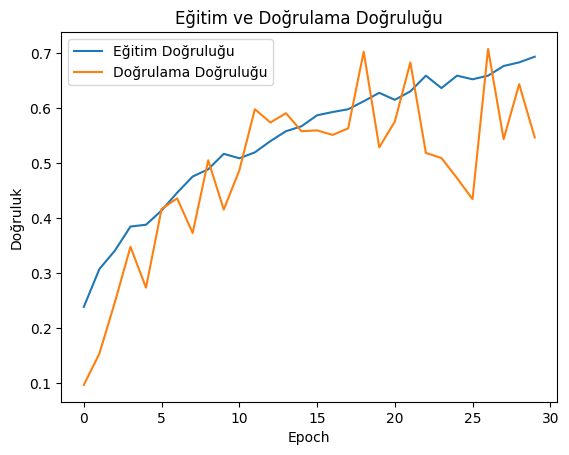

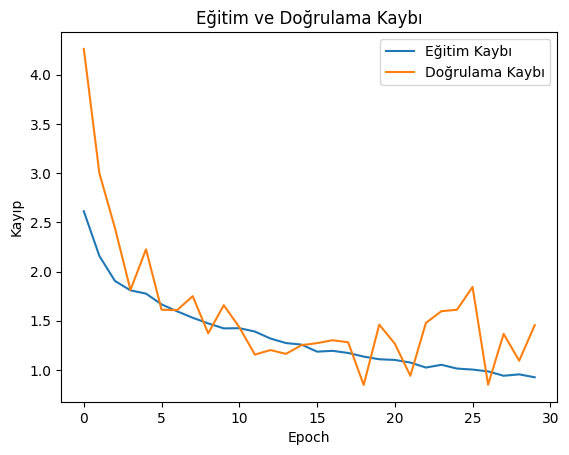

In [11]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama doğruluklarını çizme
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.legend()
plt.show()

# Eğitim ve doğrulama kayıplarını çizme
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.legend()
plt.show()

# **Adım 9: Modeli Test Etme**

In [12]:
# Test verisi üzerinde modelin doğruluğunu değerlendirme
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Doğruluğu: {test_accuracy * 100:.2f}%")
print(f"Test Kaybı: {test_loss:.4f}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5391 - loss: 1.4918
Test Doğruluğu: 54.72%
Test Kaybı: 1.4550


# **Adım 10: Test Setine Manipülasyon Uygulama**

### Manipülasyonun Genel Amacı:

Bu adımda, test setindeki her bir görüntüye iki farklı parlaklık manipülasyonu uygulayarak veri artırımı yapıyoruz. Bu manipülasyonlar, test verisini çeşitlendirmek ve modelin daha iyi genelleme yapabilmesini sağlamak için kullanılır. Sonuçta, test verisinin boyutu artırılarak modelin daha sağlam test edilmesi sağlanır.

### Kodun İşleyişi:

manipulate_images Fonksiyonu: Bu fonksiyon, bir görüntü seti alır ve her görüntü üzerinde iki çeşit parlaklık manipülasyonu uygular:

	•	Parlaklığı artırma: Görüntülerin parlaklık seviyesini artırarak ışıklı koşullarda modelin nasıl performans gösterdiği incelenir.
	•	Parlaklığı azaltma: Görüntülerin parlaklık seviyesini azaltarak karanlık koşullarda modelin nasıl performans gösterdiği test edilir.
    Fonksiyon, her iki manipülasyonu uyguladıktan sonra manipüle edilmiş görüntüleri bir listeye ekler ve son olarak bu listeyi bir NumPy dizisine dönüştürüp geri döndürür.

manipulate_images(X_test) Çağrısı:

	•	Burada, test seti olan X_test üzerinde manipulate_images fonksiyonu çağrılır. Bu işlem, her görüntü için parlaklık manipülasyonlarını uygular ve manipüle edilmiş test setini oluşturur.

Sonuç Yazdırma:

	•	Manipülasyon işleminin tamamlandığını doğrulamak için, manipüle edilmiş test setinin boyutunu ekrana yazdırır. Bu, kaç adet görüntü olduğunu ve test setinin büyüklüğünün nasıl değiştiğini gösterir.

In [13]:
def manipulate_images(image_set):
    manipulated_images = []
    for img in image_set:
        # Parlaklığı artırma
        bright_img = cv2.convertScaleAbs(img, alpha=1.1, beta=30)
        manipulated_images.append(bright_img)

        # Parlaklığı azaltma
        dark_img = cv2.convertScaleAbs(img, alpha=0.9, beta=-20)
        manipulated_images.append(dark_img)

    return np.array(manipulated_images)


# Test setine manipülasyon uygula
manipulated_X_test = manipulate_images(X_test)
print(f"Manipüle edilmiş test seti oluşturuldu: {manipulated_X_test.shape}")

Manipüle edilmiş test seti oluşturuldu: (3900, 128, 128, 3)


# **Adım 11: Manipüle Edilmiş Görüntüler ile Modeli Test Etme**

Bu adımda, test verisinde yapılan parlaklık manipülasyonlarına uygun olarak etiketleri çoğaltıyor ve ardından manipüle edilmiş test seti üzerinde modelin doğruluğunu ve kaybını değerlendiriyoruz. Bu sayede, modelin daha geniş ve çeşitlendirilmiş veri setlerine karşı nasıl performans gösterdiğini anlıyoruz

In [14]:
# Etiketleri manipüle edilmiş görüntülerle eşleştirme
# Burada, her bir orijinal görüntüye 3 manipülasyon uyguladığımız için y_test'i 3 kez çoğaltmamız gerekir.
manipulated_y_test = np.tile(y_test, 2)

print(f"Manipüle edilmiş test etiketleri oluşturuldu: {manipulated_y_test.shape}")

# Manipüle edilmiş test setinde modelin doğruluğunu ölç
manipulated_test_loss, manipulated_test_accuracy = model.evaluate(manipulated_X_test, manipulated_y_test, verbose=1)
print(f"Manipüle Edilmiş Test Doğruluğu: {manipulated_test_accuracy * 100:.2f}%")
print(f"Manipüle Edilmiş Test Kaybı: {manipulated_test_loss:.4f}")

Manipüle edilmiş test etiketleri oluşturuldu: (3900,)
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.1057 - loss: 53.3565
Manipüle Edilmiş Test Doğruluğu: 9.79%
Manipüle Edilmiş Test Kaybı: 53.5792


# **Adım 12: Manipüle Edilmiş Veri Setine Renk Sabitliği Algoritması Uygulanması**

Bu adımda, test setindeki manipüle edilmiş görüntülere Gray World algoritması ile renk sabitleme işlemi uyguluyoruz. Algoritma, her renk kanalının ortalamasını alıp, tüm kanalların ortalamasına çekerek renk dengesini sağlar.

Kodun işleyişi:

	1.Gray World Algoritması her bir kanalın ortalamasını hesaplayıp, kanal bazında dengeleme yapar.
	2.apply_color_balance_to_dataset fonksiyonu, manipüle edilmiş test setindeki her görüntüye renk sabitleme uygular.

Sonuç olarak, renk sabitlemesi yapılmış yeni bir test seti (balanced_manipulated_X_test) oluşturulur.

In [15]:
def gray_world_balance(image):
    """
    Gray World algoritması ile renk sabitliği uygular.
    """
    # Görüntünün her renk kanalının ortalamasını hesapla
    avg_b = np.mean(image[:, :, 0])  # Mavi kanal
    avg_g = np.mean(image[:, :, 1])  # Yeşil kanal
    avg_r = np.mean(image[:, :, 2])  # Kırmızı kanal

    # Tüm kanalların ortalamasını bul
    avg = (avg_b + avg_g + avg_r) / 3

    # Kanal bazında dengeleme yap
    image[:, :, 0] = np.clip(image[:, :, 0] * (avg / avg_b), 0, 255)  # Mavi
    image[:, :, 1] = np.clip(image[:, :, 1] * (avg / avg_g), 0, 255)  # Yeşil
    image[:, :, 2] = np.clip(image[:, :, 2] * (avg / avg_r), 0, 255)  # Kırmızı

    return image.astype(np.uint8)  # Görüntüyü uint8 formatına çevir

def apply_color_balance_to_dataset(image_set):
    """
    Veri setindeki tüm görüntülere renk sabitliği uygular.
    """
    balanced_images = []
    for img in image_set:
        balanced_img = gray_world_balance(img)
        balanced_images.append(balanced_img)
    return np.array(balanced_images)

# Manipüle edilmiş test setine renk sabitliği uygula
balanced_manipulated_X_test = apply_color_balance_to_dataset(manipulated_X_test)

print(f"Renk sabitliği uygulanmış manipüle edilmiş veri seti oluşturuldu: {balanced_manipulated_X_test.shape}")

Renk sabitliği uygulanmış manipüle edilmiş veri seti oluşturuldu: (3900, 128, 128, 3)


# **Adım 13: Modelin Renk Sabitliği Uygulanmış Test Seti ile Denenmesi**

Bu adımda, renk sabitlemesi yapılmış ve manipüle edilmiş test setiyle modelin doğruluğunu test ediyoruz. Etiketler her görüntü için iki katına çıkarılıyor çünkü her görüntüye iki manipülasyon uygulanıyor. Model tahminlerini yapar ve doğru etiketlerle karşılaştırarak doğruluğu hesaplar. Sonuç, modelin doğruluğu olarak yazdırılıyor.

In [24]:
# Manipüle edilmiş veri setine uygun şekilde etiketleri genişlet
manipulated_labels = np.repeat(y_test, 2)  # Her bir görüntü için 2 manipülasyon yapıldığını varsayıyoruz

print(f"Manipüle edilmiş etiketlerin boyutu: {manipulated_labels.shape}")

# Modeli manipüle edilmiş veri setiyle test et
predictions = model.predict(balanced_manipulated_X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Doğruluğu hesapla
accuracy = np.mean(predicted_labels == manipulated_labels)
print(f"Renk sabitliği yapılmış manipüle edilmiş test seti doğruluğu: {accuracy * 100:.2f}%")

Manipüle edilmiş etiketlerin boyutu: (3900,)
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step
Renk sabitliği yapılmış manipüle edilmiş test seti doğruluğu: 9.79%
